From an SPE file of dark images, create a median combined master dark fits file.

In [1]:
cd '..'

/Users/keatonb/github/reduceSPE


In [2]:
# Imports.
# Standard libraries.
from __future__ import absolute_import, division, print_function
import os
import csv
import sys
import datetime as dt
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
# Installed packages.
from astropy.io import fits
import pandas as pd
from bs4 import BeautifulSoup
# Local modules.
import read_spe

%matplotlib inline

In [3]:
#Read in SPE data
file_path = 'exampleSPEdata'
file_name = 'dark_3s.spe'
file_full = os.path.join(file_path, file_name)
spe = read_spe.File(file_full)

/Users/keatonb/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


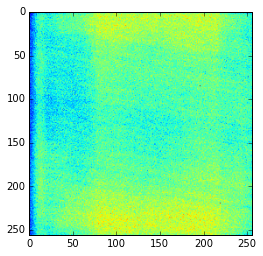

In [4]:
#How many frames?
num_frames=spe.get_num_frames()
#get all frames in SPE file
#stack as 3D numpy array
(frames,_)=spe.get_frame(0)
frames=np.array([frames])
for i in range(1,num_frames):
    (thisframe,_)=spe.get_frame(i)
    frames=np.concatenate((frames,[thisframe]),0)

#median combine the frames
master=np.median(frames,axis=0)

#display the output
plt.imshow(master)

Min: 0.0
Max: 0.0
Mean: 0.0
Stdev: 0.0


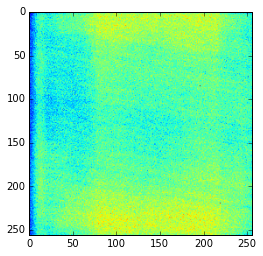

In [5]:
#compare with output of IRAF imcombine
iraffits="exampleSPEdata/Dark_3s_IRAF.fits"
hdu_list = fits.open(iraffits)
plt.imshow(hdu_list[0].data[0])

#confirm that these are the same from a difference image
# -> Confirmed!
diff = master - hdu_list[0].data[0]
print('Min:', np.min(diff))
print('Max:', np.max(diff))
print('Mean:', np.mean(diff))
print('Stdev:', np.std(diff))

In [8]:
#Write master dark to fits file

#compile header information
prihdr = fits.Header()
prihdr['OBJECT'] = 'dark'
prihdr['IMAGETYP'] = 'dark'

if hasattr(spe, 'footer_metadata'):
    footer_metadata = BeautifulSoup(spe.footer_metadata, "xml")
    ts_begin = footer_metadata.find(name='TimeStamp', event='ExposureStarted').attrs['absoluteTime']
    dt_begin = dateutil.parser.parse(ts_begin)
    prihdr['TICKRATE'] = int(footer_metadata.find(name='TimeStamp', event='ExposureStarted').attrs['resolution'])
    prihdr['DATE-OBS'] = str(dt_begin.isoformat())
    prihdr['XBIN'] = footer_metadata.find(name="SensorMapping").attrs['xBinning']
    prihdr['YBIN'] = footer_metadata.find(name="SensorMapping").attrs['yBinning']
    prihdr['INSTRUME'] = footer_metadata.find(name="Camera").attrs['model']
    prihdr['TRIGGER'] = footer_metadata.find(name='TriggerResponse').text
    prihdr['COMMENT'] = "SPE file has footer metadata"
    prihdr['EXPTIME'] = str(float(footer_metadata.find(name='ExposureTime').text)/1000.)
    #prihdr['SOFTWARE'] = footer_metadata.find(name='Origin')
    prihdr['SHUTTER'] = footer_metadata.find(name='Mode').text
    if footer_metadata.find(name='Mode').text != 'AlwaysClosed':
        prihdr['WARNING'] = 'Shutter not closed for dark frame.'
        print("WARNING: Shutter not closed for dark frame.")
else:
    prihdr['WARNING'] = "No XML footer metadata."
    print("WARNING: No XML footer metadata.")
    
    
print(prihdr)
    
    
#put it all together
hdu = fits.PrimaryHDU(master,header=prihdr)

#write it out
fitsfilename = 'master_'+file_name.split('.spe')[0]+'.fits'
hdu.writeto(os.path.join(file_path, fitsfilename),clobber=True)

OBJECT  = 'dark    '                                                            IMAGETYP= 'dark    '                                                            TICKRATE=              1000000                                                  DATE-OBS= '2015-06-09T01:15:02.821674+00:00'                                    XBIN    = '4       '                                                            YBIN    = '4       '                                                            INSTRUME= 'ProEM: 1024B'                                                        TRIGGER = 'ReadoutPerTrigger'                                                   EXPTIME = '2.998   '                                                            SHUTTER = 'AlwaysClosed'                                                        COMMENT SPE file has footer metadata                                            END                                                                                                                     